Funziona
https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/

In [1]:
# importing required packages...
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
#from patchify import patchify
from PIL import Image
#import segmentation_models as sm
import tensorflow as tf
#from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#from tensorflow.keras.models import load_model
from tqdm import tqdm
from keras.utils import normalize
from tensorflow import keras
from keras.utils import to_categorical
import random
import segmentation_models as sm #pip install segmentation_models
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from tensorflow.keras import layers
import pickle
#from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
#from tensorflow.keras.optimizers import SGD, Adam

Segmentation Models: using `keras` framework.


In [2]:
# loading image data...
def data_loader(folder_dir):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        #print(path)
        image = cv2.imread(path, 0)
        #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        #image = Image.fromarray(image)
        #image = np.array(image)
        image_dataset.append(image)
    return image_dataset

In [3]:
parent = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) #parent directory
img_folder = os.path.join("..", "original-dataset", "images")
masks_folder = os.path.join("..", "original-dataset", "masks")
n_classes = 5 # class for segmentation

image_dataset = data_loader(img_folder) # real images...
mask_dataset = data_loader(masks_folder) # masked images...
image_dataset = np.array(image_dataset)
image_dataset = np.expand_dims(image_dataset, axis = 3)
mask_dataset = np.array(mask_dataset)


In [4]:
print("Image dataset: " ,image_dataset.shape)
print("Mask dataset: ",mask_dataset.shape)
print(image_dataset[0].shape)
print(mask_dataset[0].shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

(211, 128, 128, 1)
(211, 128, 128)
(128, 128, 1)
(128, 128)
Max pixel value in image is:  255
Labels in the mask are :  [0 1 2 3 4]


In [12]:
#Encode labels to 0, 1, 2, 3, ... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape  
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)
mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
print(mask_dataset_encoded.shape)

#Normalize images
image_dataset = image_dataset /255. 


c:\Users\Lucia\Desktop\Università\Deep Learning\jupyter\.env\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(211, 128, 128, 1)
(168, 128, 128, 1)
(43, 128, 128, 1)


In [14]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)
     

(128, 128, 1)
(128, 128, 1)


In [16]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))
print(y_train.shape)
print(y_train_cat.shape)


(168, 128, 128, 1)
(168, 128, 128, 5)


In [24]:
print(X_train.shape)
print(X_test.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)

(168, 128, 128, 1)
(43, 128, 128, 1)
(168, 128, 128, 5)
(43, 128, 128, 5)


ValueError: Expected image array to have rank 3 (single image). Got array with shape: (128, 5)

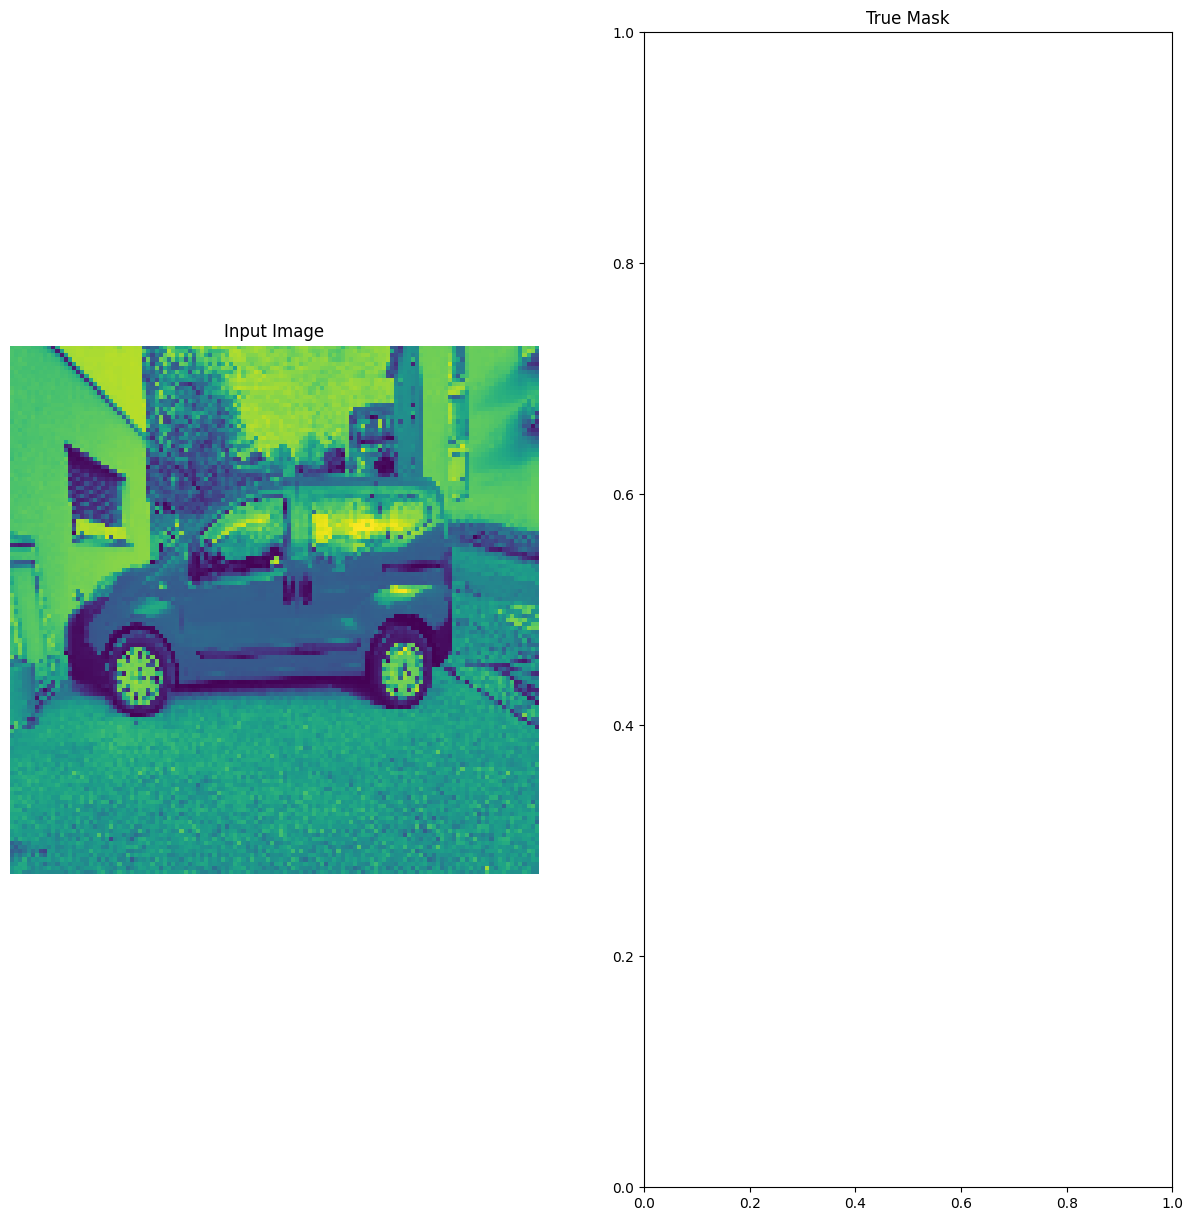

In [11]:
def display(display_list):
 plt.figure(figsize=(15, 15))
 title = ["Input Image", "True Mask", "Predicted Mask"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()
 

random_index = 0
simg, smask = X_train[random_index], y_train[1][random_index]
display([simg, smask])

In [29]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [30]:
def build_unet_model(n_classes):
    # inputs
   inputs = layers.Input(shape=(128,128,1))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(n_classes, 1, padding="same", activation = "softmax")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model
model = build_unet_model(n_classes)

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="categorical_crossentropy",
                  metrics="accuracy")
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 64  640         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_38[0][0]']              
                                )                                                             

In [32]:
callbacks =[keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)]
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=25, 
                    validation_data=(X_test, y_test_cat), 
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/25
11/11 [==============================] - 318s 29s/step - loss: 1.9624 - accuracy: 0.5897 - val_loss: 1.5575 - val_accuracy: 0.6007
Epoch 2/25
11/11 [==============================] - 185s 16s/step - loss: 1.5731 - accuracy: 0.5898 - val_loss: 1.5170 - val_accuracy: 0.6533
Epoch 3/25
11/11 [==============================] - 145s 13s/step - loss: 1.4039 - accuracy: 0.6469 - val_loss: 1.2767 - val_accuracy: 0.6533
Epoch 4/25
11/11 [==============================] - 126s 11s/step - loss: 1.1046 - accuracy: 0.6462 - val_loss: 0.9871 - val_accuracy: 0.6533
Epoch 5/25
11/11 [==============================] - 126s 11s/step - loss: 0.9793 - accuracy: 0.6468 - val_loss: 0.9342 - val_accuracy: 0.6533
Epoch 6/25
11/11 [==============================] - 123s 11s/step - loss: 0.9302 - accuracy: 0.6469 - val_loss: 0.8500 - val_accuracy: 0.6533
Epoch 7/25
11/11 [==============================] - 125s 11s/step - loss: 0.9650 - accuracy: 0.6442 - val_loss: 0.9395 - val_accuracy: 0.6533
Epoch 

In [33]:
model.save(os.path.join("..",'UNet7_25_epochs.hdf5'))

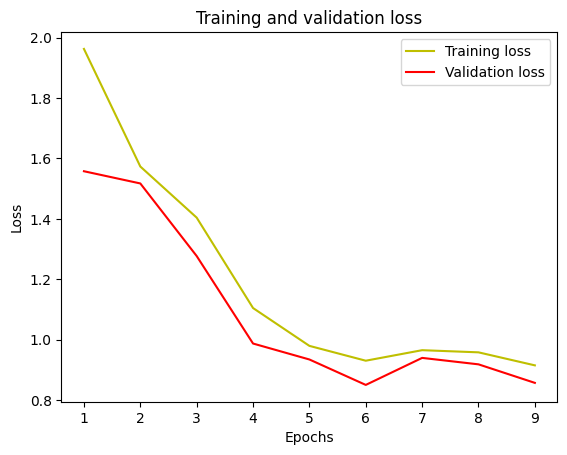

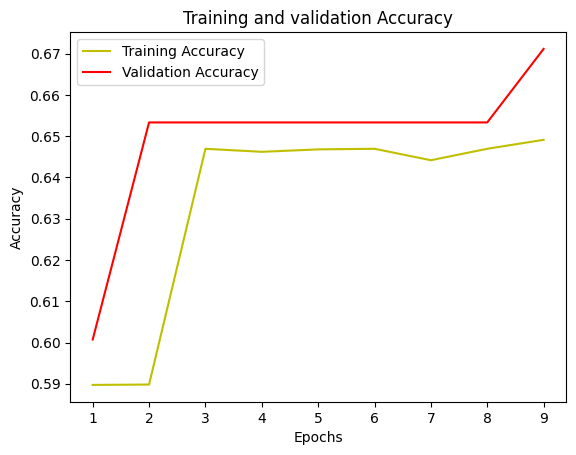

In [34]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [36]:
### Fit and Evaluate the model
score = model.evaluate(X_test, y_test_cat, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 5s 1s/step - loss: 0.8568 - accuracy: 0.6711
Test loss: 0.856816828250885
Test accuracy: 0.671138346195221


1/1 [==============================] - 0s 149ms/step


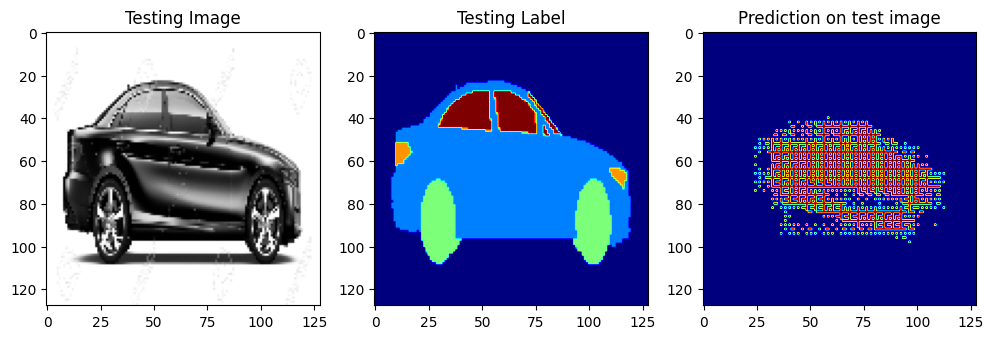

In [45]:
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()